# Introduction
This notebook will test the performance of a 2-layer MLP (multi-layer perceptron) in performing a character-wise prediction task on 
* MNIST
* the play *Hamlet*. 

In [32]:
# imports
from tqdm import tnrange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import gc
import os
%matplotlib inline  

# alphabet
import string

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# MLP code

## Data preparation

In [2]:
def get_accuracy(logit, target):
    batch_size = len(target)
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

def nparam(ninputs,nhidden,noutputs):
    return ninputs*(nhidden+1) + nhidden*(nhidden+1)+nhidden*(noutputs+1)

def nparam(ninputs,nhidden,noutputs):
    return ninputs*(nhidden+1) + nhidden*(nhidden+1)+ nhidden*(noutputs+1)


## Model

In [37]:
# a prototype MLP
class MLP(nn.Module):
    def __init__(self, n_inputs, n_hidden_neurons, n_output,  device):
        super(MLP, self).__init__()
        self.n_inputs = n_inputs # set the number of neurons in the input layer
        self.n_hidden_neurons = n_hidden_neurons # how many neurons are in each hidden layer
        #self.n_hidden_layers = n_hidden_layers # how many hidden layers are we using in our model
        self.n_output = n_output # set the number of neurons in the output layer
        self.dt = nn.Parameter(torch.Tensor([1])) # set the change in parameter update
        self.a = nn.Parameter(torch.Tensor([1])) # set the bias
        self.sig = nn.Sigmoid() # set the activation function 
        self.n_hidden = n_hidden_neurons
        self.decoder = nn.Linear(n_hidden_neurons, n_output) # decode output
        self.recurrent = nn.Linear(n_hidden_neurons,n_hidden_neurons)
        self.encoder = nn.Linear(n_inputs, n_hidden_neurons) # encode input
        
    # the main operation for the MLP is to update each hidden layer with the state of the previous hidden layer
    # so, if you need to update the hidden layers, make sure you update each layer with state of the previous layer
    
#     def update_hidden_layer(self):
#         # update the neurons in the current hidden layer with the state of the inputted "previous" layer
#         for i in range(1,self.n_hidden_layers):
#             # update each node in the h1_current
#             self.h1 = self.hidden
# #             self.hidden = nn.Linear(self.h1,self.hidden) # update the stored hidden layer state as many times as there are hidden layers specified # BUG
#             # the nn.Linear should take in the shape...
#             self.hidden = nn.Linear(self.n_hidden_neurons,self.n_hidden_neurons) 
#         self.h1 = self.hidden
#         return(self.h1)
    
    def forward(self, x0):
        #x0=x0.permute(1,0,2) # permute the tensor
        # save the hidden layers as a tensor
        
        # initialize self.h1
        self.hidden1 = self.sig(self.encoder(x0))#torch.zeros(self.n_hidden_layers,BATCH_SIZE,self.n_hidden).to(device) # initialize the hidden layer
        self.hidden2 = self.sig(self.recurrent(self.hidden1))
        self.output = self.decoder(self.hidden2)
        
        
#         # set the hidden layer value
#         for i in range(x0.size(0)):
#             self.hidden[0,:,:] = self.sig(self.dt)*self.a*torch.tanh(self.encoder(x0[i,:,:]))
        
#         self.hidden = torch.zeros(self.n_hidden_layers,BATCH_SIZE,self.n_hidden).to(device) # initialize the hidden layer
        # the first layer will consist of the encoded inputs
#         for i in range(x0.size(0)):
#             self.hlayers[0,:,:] = self.sig(self.dt)*self.a*torch.tanh(self.encoder(x0[i,:,:])) # (1-self.sig(self.dt))*self.h1+self.sig(self.dt)*self.a*torch.tanh(self.encoder(x0[i,:,:])+self.recurrent(self.h1))
#         # update the additional hidden layers
        #self.hidden = self.update_hidden_layer()

        #self.y1 = self.decoder(self.n_hidden_neurons,self.n_output)
        return self.output

# Load data

In [38]:
# MNIST

BATCH_SIZE = 100

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# Train on MNIST

In [53]:
# training on MNIST
# parameters 
N_INPUTS = 784
N_HIDDEN_NEURONS = 100
N_OUTPUTS = 10
N_EPHOCS = 10

model = MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS,device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train_running_loss = np.zeros(N_EPHOCS)
train_acc = np.zeros(N_EPHOCS)
nparams = 0
for param in model.parameters(): 
    if param.requires_grad:
        nparams += param.data.numpy().size
Phist = np.zeros((nparams,N_EPHOCS))

for epoch in range(N_EPHOCS):
    nps = 0
    running_loss=0
    running_acc=0
    for p,param in enumerate(model.parameters()):
        if param.requires_grad:
            plist = param.data.numpy().flatten()
            for j in range(plist.size):
                Phist[nps,epoch]=plist[j]
                nps+=1
  
    for i, data in enumerate(trainloader):
        
        optimizer.zero_grad()
        x, y_tar = data
        y_pred = model(x.view(BATCH_SIZE,N_INPUTS))
        loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar)
                
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar)
    train_running_loss[epoch] = running_loss
    train_acc[epoch] = running_acc/i
    
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' %(epoch, train_running_loss[epoch], train_acc[epoch]))

Epoch:  0 | Loss: 286.1397 | Train Accuracy: 85.11
Epoch:  1 | Loss: 83.2102 | Train Accuracy: 96.04
Epoch:  2 | Loss: 57.3114 | Train Accuracy: 97.32
Epoch:  3 | Loss: 43.6119 | Train Accuracy: 97.97
Epoch:  4 | Loss: 34.4946 | Train Accuracy: 98.40
Epoch:  5 | Loss: 27.4446 | Train Accuracy: 98.76
Epoch:  6 | Loss: 22.0844 | Train Accuracy: 99.01
Epoch:  7 | Loss: 16.5204 | Train Accuracy: 99.36
Epoch:  8 | Loss: 13.3614 | Train Accuracy: 99.59
Epoch:  9 | Loss: 11.0588 | Train Accuracy: 99.66


In [54]:
torch.max(y_pred,1)[1]

tensor([7, 6, 4, 1, 3, 3, 2, 9, 9, 0, 1, 4, 3, 9, 5, 8, 9, 8, 2, 5, 3, 4, 6, 6,
        7, 6, 7, 4, 4, 5, 5, 9, 0, 6, 7, 1, 2, 9, 5, 7, 4, 1, 4, 2, 4, 8, 6, 8,
        7, 7, 7, 2, 9, 0, 0, 4, 8, 4, 9, 9, 2, 7, 6, 4, 3, 2, 8, 1, 3, 7, 9, 0,
        1, 3, 0, 9, 4, 8, 8, 6, 8, 8, 3, 3, 8, 6, 1, 7, 8, 3, 8, 3, 0, 5, 0, 6,
        8, 3, 6, 5])

In [55]:
y

tensor([5, 9, 5, 8, 0, 8, 4, 8, 6, 1, 5, 6, 8, 1, 2, 3, 0, 1, 9, 4, 3, 0, 4, 5,
        3, 4, 1, 1, 8, 1, 8, 3, 3, 3, 2, 0, 2, 0, 5, 9, 4, 8, 3, 0, 5, 9, 8, 9,
        2, 4, 4, 6, 7, 2, 5, 3, 4, 3, 1, 6, 3, 3, 4, 3, 4, 9, 2, 0, 8, 2, 8, 6,
        4, 8, 5, 5, 6, 0, 0, 1, 8, 1, 7, 6, 9, 8, 6, 6, 6, 6, 6, 3, 5, 5, 1, 9,
        6, 1, 7, 2])

## MLP with regularization

In [96]:
# parameters 
N_INPUTS = 784
N_HIDDEN_NEURONS = 100
N_OUTPUTS = 10
N_EPHOCS = 5
N_REPS = 2
N_PARAMS = nparam(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS)

# regularization parameters
lambdas = np.arange(0,1e-2,3e-3,dtype=np.float)
N_LAMBDA = len(lambdas)
gidx = int(N_HIDDEN_NEURONS/2)

In [97]:
# regularizing digonal blocks of the partitioned RNN
train_loss_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
train_acc_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_loss_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_acc_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
Phist_P = np.zeros((N_PARAMS,N_EPHOCS,N_LAMBDA,N_REPS))

model_P = [None]*N_LAMBDA*N_REPS
regval_P = []
for r in tnrange(N_REPS):
    for k in tnrange(N_LAMBDA):
        reg_lambda = lambdas[k]
        # model_path = 'D:\chongguo\git\AM221pset\Project\Final Project\History\Lamb\model_P_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10))
        model_path = '/Users/vinayakvsv/am221/AM221pset/Project/vv_sandbox/mlp_experiments/model_P_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10))
        # model_P[k+r*N_LAMBDA] = PRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,1,device).to(device)
        model_P[k+r*N_LAMBDA] = MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS,device)
        l2_reg = torch.Tensor(1,device=device)
        optimizer = torch.optim.SGD(model_P[k+r*N_LAMBDA].parameters(), lr=1e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(N_EPHOCS):
            nps = 0
            running_train_loss=0
            running_train_acc=0
            model_P[k+r*N_LAMBDA].train()
            for p, param in enumerate(model_P[k+r*N_LAMBDA].parameters()):
                if param.requires_grad:
                    plist = torch.flatten(param.data)
                    for j in range(plist.size(0)):
                        Phist_P[nps,epoch,k,r]=plist[j].item()
                        nps+=1

            for i, (x, y_tar) in enumerate(trainloader):
                l2_reg = 0
                x, y_tar = x.to(device), y_tar.to(device)
                optimizer.zero_grad()
                y_pred = model_P[k+r*N_LAMBDA](x.view(BATCH_SIZE,N_INPUTS))
                loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar)
                for p,param in enumerate(model_P[k+r*N_LAMBDA].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN_NEURONS and param.shape[1]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:gidx,:gidx].norm(p=1)
                            l2_reg = l2_reg + param[gidx:,gidx:].norm(p=1)
                        elif param.shape[1]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:,gidx:].norm(p=1)
                        elif param.shape[0]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:gidx,:].norm(p=1)
                regval_P.append(l2_reg.item())
                loss = loss + l2_reg*reg_lambda/BATCH_SIZE
                loss.backward()
                optimizer.step()
                running_train_loss+=loss.item()
                running_train_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar)
            
            running_test_acc=0
            running_test_loss=0
            model_P[k+r*N_LAMBDA].eval()
            for i,(x_test, y_test_tar) in enumerate(testloader):
                x_test, y_test_tar = x_test.to(device), y_test_tar.to(device)
                y_test_pred = model_P[k+r*N_LAMBDA](x_test.view(BATCH_SIZE,N_INPUTS))
                loss = criterion(y_test_pred.view(BATCH_SIZE,N_OUTPUTS),y_test_tar)
                running_test_loss+=loss.item()
                running_test_acc+=get_accuracy(y_test_pred.view(BATCH_SIZE,N_OUTPUTS), y_test_tar)
                
            train_loss_P[epoch,k,r] = running_train_loss/len(trainloader)
            train_acc_P[epoch,k,r] = running_train_acc/len(trainloader)
            test_loss_P[epoch,k,r] = running_test_loss/len(testloader)
            test_acc_P[epoch,k,r] = running_test_acc/len(testloader)
            
        # save the model and free the memory  
        torch.save(model_P[k+r*N_LAMBDA].state_dict(), model_path)
        model_P[k+r*N_LAMBDA] = [None]
        del(l2_reg,loss,optimizer,criterion,plist,param)

In [98]:
# regularizing random elements of the matrix
train_loss_R = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
train_acc_R = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_loss_R = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_acc_R = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
Phist_R = np.zeros((N_PARAMS,N_EPHOCS,N_LAMBDA,N_REPS))

model_R =  [None] * N_LAMBDA*N_REPS
regval_R = []
for r in tnrange(N_REPS):
    # generate a random binary mask for the parameter
    rndmask = torch.FloatTensor(N_HIDDEN_NEURONS, N_HIDDEN_NEURONS).uniform_() > 0.5
    while not rndmask.float().norm(p=1)==int(N_HIDDEN_NEURONS**2/2):
        if rndmask.float().norm(p=1)>int(N_HIDDEN_NEURONS**2/2):
            while True:
                rndidx = np.random.randint(N_HIDDEN_NEURONS,size=(2))
                if rndmask[rndidx[0],rndidx[1]]==1:
                    rndmask[rndidx[0],rndidx[1]]=0
                    break
        else:
            while True:
                rndidx = np.random.randint(N_HIDDEN_NEURONS,size=(2))
                if rndmask[rndidx[0],rndidx[1]]==0:
                    rndmask[rndidx[0],rndidx[1]]=1
                    break
    rndmask = rndmask.to(device)
    for k in tnrange(N_LAMBDA):
        reg_lambda = lambdas[k]
        model_path = '/Users/vinayakvsv/am221/AM221pset/Project/vv_sandbox/mlp_experiments/model_P_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10))
        # model_P[k+r*N_LAMBDA] = PRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,1,device).to(device)
        model_R[k+r*N_LAMBDA] = MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS,device)
        l2_reg = torch.Tensor(1,device=device)
        optimizer = torch.optim.SGD(model_R[k+r*N_LAMBDA].parameters(), lr=1e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(N_EPHOCS):
            nps = 0
            running_train_loss=0
            running_train_acc=0
            model_R[k+r*N_LAMBDA].train()
            for p, param in enumerate(model_R[k+r*N_LAMBDA].parameters()):
                if param.requires_grad:
                    plist = torch.flatten(param.data)
                    for j in range(plist.size(0)):
                        Phist_R[nps,epoch,k,r]=plist[j].item()
                        nps+=1
                        
            for i, (x, y_tar) in enumerate(trainloader):
                l2_reg = 0
                x, y_tar = x.to(device), y_tar.to(device)
                optimizer.zero_grad()
                y_pred = model_R[k+r*N_LAMBDA](x.view(BATCH_SIZE,N_INPUTS))
                loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar)
                for p,param in enumerate(model_R[k+r*N_LAMBDA].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN_NEURONS and param.shape[1]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + torch.masked_select(param,rndmask).norm(p=1)
                        elif param.shape[1]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:,gidx:].norm(p=1)
                        elif param.shape[0]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:gidx,:].norm(p=1)
                regval_R.append(l2_reg.item())
                loss = loss + l2_reg*reg_lambda/BATCH_SIZE
                loss.backward()
                optimizer.step()
                running_train_loss+=loss.item()
                running_train_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar)
              
            running_test_acc=0
            running_test_loss=0
            model_R[k+r*N_LAMBDA].eval()
            for i,(x_test, y_test_tar) in enumerate(testloader):
                x_test, y_test_tar = x_test.to(device), y_test_tar.to(device)
                y_test_pred = model_R[k+r*N_LAMBDA](x_test.view(BATCH_SIZE,N_INPUTS))
                running_test_loss+=loss.item()
                running_test_acc+=get_accuracy(y_test_pred.view(BATCH_SIZE,N_OUTPUTS), y_test_tar)
              
            train_loss_R[epoch,k,r] = running_train_loss/len(trainloader)
            train_acc_R[epoch,k,r] = running_train_acc/len(trainloader)
            test_loss_R[epoch,k,r] = running_test_loss/len(testloader)
            test_acc_R[epoch,k,r] = running_test_acc/len(testloader)
            
        # save the model and free the memory  
        torch.save(model_R[k+r*N_LAMBDA].state_dict(), model_path)
        model_R[k+r*N_LAMBDA] = [None]
        del(l2_reg,loss,optimizer,criterion,plist,param)

In [99]:
# regularizing off-digonal blocks of the partitioned RNN
train_loss_C = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
train_acc_C = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_loss_C = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_acc_C = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
Phist_C = np.zeros((N_PARAMS,N_EPHOCS,N_LAMBDA,N_REPS))

model_C =  [None] * N_LAMBDA*N_REPS
regval_C = []
for r in tnrange(N_REPS):
    for k in tnrange(N_LAMBDA):
        reg_lambda = lambdas[k]
        model_path = '/Users/vinayakvsv/am221/AM221pset/Project/vv_sandbox/mlp_experiments/model_P_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10))
        # model_P[k+r*N_LAMBDA] = PRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,1,device).to(device)
        model_C[k+r*N_LAMBDA] = MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS,device)
        l2_reg = torch.Tensor(1,device=device)
        optimizer = torch.optim.SGD(model_C[k+r*N_LAMBDA].parameters(), lr=1e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(N_EPHOCS):
            nps = 0
            running_train_loss=0
            running_train_acc=0
            model_C[k+r*N_LAMBDA].train()
            for p, param in enumerate(model_C[k+r*N_LAMBDA].parameters()):
                if param.requires_grad:
                    plist = torch.flatten(param.data)
                    for j in range(plist.size(0)):
                        Phist_C[nps,epoch,k,r]=plist[j].item()
                        nps+=1

            for i, (x, y_tar) in enumerate(trainloader):
                l2_reg = 0
                x, y_tar = x.to(device), y_tar.to(device)
                optimizer.zero_grad()
                y_pred = model_C[k+r*N_LAMBDA](x.view(BATCH_SIZE,N_INPUTS))
                loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar)
                for p,param in enumerate(model_C[k+r*N_LAMBDA].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN_NEURONS and param.shape[1]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:gidx,gidx:].norm(p=1)
                            l2_reg = l2_reg + param[gidx:,:gidx].norm(p=1)
                        elif param.shape[1]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:,gidx:].norm(p=1)
                        elif param.shape[0]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:gidx,:].norm(p=1)
                regval_C.append(l2_reg.item())
                loss = loss + l2_reg*reg_lambda/BATCH_SIZE
                loss.backward()
                optimizer.step()
                running_train_loss+=loss.item()
                running_train_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar)
              
            running_test_acc=0
            running_test_loss=0
            model_C[k+r*N_LAMBDA].eval()
            for i,(x_test, y_test_tar) in enumerate(testloader):
                x_test, y_test_tar = x_test.to(device), y_test_tar.to(device)
                y_test_pred = model_C[k+r*N_LAMBDA](x_test.view(BATCH_SIZE,N_INPUTS))
                running_test_loss+=loss.item()
                running_test_acc+=get_accuracy(y_test_pred.view(BATCH_SIZE,N_OUTPUTS), y_test_tar)
              
            train_loss_C[epoch,k,r] = running_train_loss/len(trainloader)
            train_acc_C[epoch,k,r] = running_train_acc/len(trainloader)
            test_loss_C[epoch,k,r] = running_test_loss/len(testloader)
            test_acc_C[epoch,k,r] = running_test_acc/len(testloader)
            
        # save the model and free the memory  
        torch.save(model_C[k+r*N_LAMBDA].state_dict(), model_path)
        model_C[k+r*N_LAMBDA] = [None]
        del(l2_reg,loss,optimizer,criterion,plist,param)

In [100]:
# plt.figure(figsize=(14,5))
# plt.subplot(1,2,1)
# sidx = int((N_INPUTS+N_OUTPUTS+1)*N_HIDDEN)
# ridx = int(N_HIDDEN*N_HIDDEN)
# rval_P = np.asarray(regval_P)
# rval_P = np.mean(rval_P.reshape(N_REPS,int(len(rval_P)/N_REPS)).T,axis=1)
# rval_P = rval_P.reshape(N_LAMBDA,int(len(rval_P)/N_LAMBDA)).T
# rval_C = np.asarray(regval_C)
# rval_C = np.mean(rval_C.reshape(N_REPS,int(len(rval_C)/N_REPS)).T,axis=1)
# rval_C = rval_C.reshape(N_LAMBDA,int(len(rval_C)/N_LAMBDA)).T
# rval_R = np.asarray(regval_R)
# rval_R = np.mean(rval_R.reshape(N_REPS,int(len(rval_R)/N_REPS)).T,axis=1)
# rval_R = rval_R.reshape(N_LAMBDA,int(len(rval_R)/N_LAMBDA)).T
# plt.plot(lambdas,rval_P[-1,],label='diagonal')
# plt.plot(lambdas,rval_C[-1,],label='off-diagonal')
# plt.plot(lambdas,rval_R[-1,],label='random')
# plt.title('L1 norm of regularized hidden-hidden weight')
# plt.ylabel('L1 norm')
# plt.xlabel('lambda')
# plt.subplot(1,2,2)
# plt.plot(lambdas,np.mean(np.sum(np.abs(Phist_P[sidx:(sidx+ridx),-1,:,:].squeeze())<0.0025,axis=0),axis=1)/ridx,'-',label='diagonal')
# plt.plot(lambdas,np.mean(np.sum(np.abs(Phist_C[sidx:(sidx+ridx),-1,:,:].squeeze())<0.0025,axis=0),axis=1)/ridx,'-',label='off-diagonal')
# plt.plot(lambdas,np.mean(np.sum(np.abs(Phist_R[sidx:(sidx+ridx),-1,:,:].squeeze())<0.0025,axis=0),axis=1)/ridx,'-',label='random')
# plt.plot(lambdas,0.5*np.ones_like(lambdas),'k--')
# plt.ylim((0,.55))
# plt.legend()
# plt.title('Fraction of zero weight')
# plt.xlabel('lambda')
# plt.ylabel('Fraction')
# plt.show()
for p,param in enumerate(model.parameters()):
    if param.requires_grad:
        print(param.shape)

torch.Size([1])
torch.Size([1])
torch.Size([10, 100])
torch.Size([10])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])


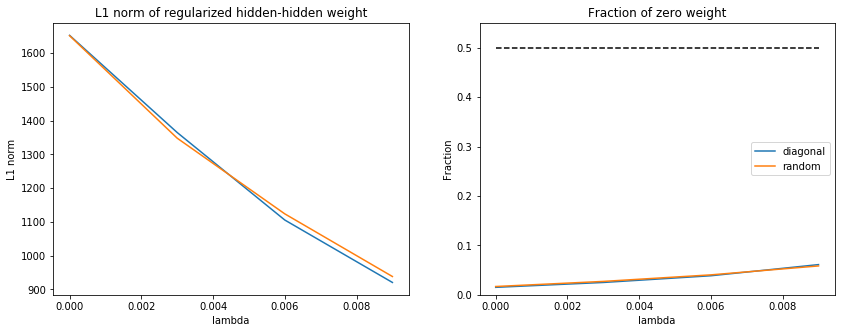

In [101]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sidx = int(N_OUTPUTS*(1+N_HIDDEN_NEURONS)+2)
ridx = int(N_HIDDEN_NEURONS*N_HIDDEN_NEURONS)
rval_P = np.asarray(regval_P)
rval_P = np.mean(rval_P.reshape(N_REPS,int(len(rval_P)/N_REPS)).T,axis=1)
rval_P = rval_P.reshape(N_LAMBDA,int(len(rval_P)/N_LAMBDA)).T
rval_C = np.asarray(regval_C)
rval_C = np.mean(rval_C.reshape(N_REPS,int(len(rval_C)/N_REPS)).T,axis=1)
rval_C = rval_C.reshape(N_LAMBDA,int(len(rval_C)/N_LAMBDA)).T
rval_R = np.asarray(regval_R)
rval_R = np.mean(rval_R.reshape(N_REPS,int(len(rval_R)/N_REPS)).T,axis=1)
rval_R = rval_R.reshape(N_LAMBDA,int(len(rval_R)/N_LAMBDA)).T
plt.plot(lambdas,rval_P[-1,],label='diagonal')
# plt.plot(lambdas,rval_C[-1,],label='off-diagonal')
plt.plot(lambdas,rval_R[-1,],label='random')
plt.title('L1 norm of regularized hidden-hidden weight')
plt.ylabel('L1 norm')
plt.xlabel('lambda')
plt.subplot(1,2,2)
plt.plot(lambdas,np.mean(np.sum(np.abs(Phist_P[sidx:(sidx+ridx),-1,:,:].squeeze())<0.0025,axis=0),axis=1)/ridx,'-',label='diagonal')
# plt.plot(lambdas,np.mean(np.sum(np.abs(Phist_C[sidx:(sidx+ridx),-1,:,:].squeeze())<0.0025,axis=0),axis=1)/ridx,'-',label='off-diagonal')
plt.plot(lambdas,np.mean(np.sum(np.abs(Phist_R[sidx:(sidx+ridx),-1,:,:].squeeze())<0.0025,axis=0),axis=1)/ridx,'-',label='random')
plt.plot(lambdas,0.5*np.ones_like(lambdas),'k--')
plt.ylim((0,.55))
plt.legend()
plt.title('Fraction of zero weight')
plt.xlabel('lambda')
plt.ylabel('Fraction')
plt.show()

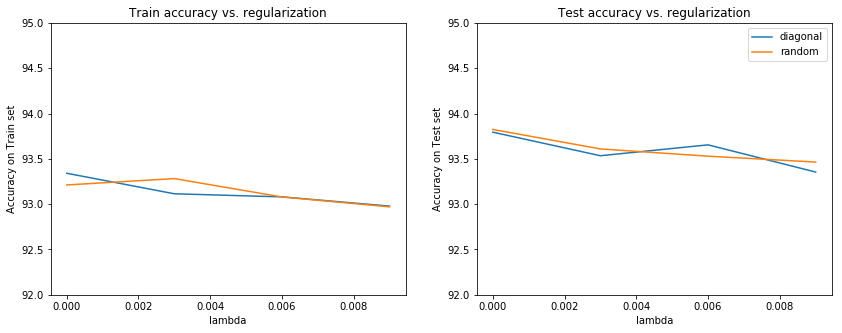

In [102]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(lambdas,np.mean(train_acc_P[-1,:,:].squeeze(),axis = 1).T,'-')
# plt.plot(lambdas,np.mean(train_acc_C[-1,:,:].squeeze(),axis = 1).T,'-')
plt.plot(lambdas,np.mean(train_acc_R[-1,:,:].squeeze(),axis = 1).T,'-')
plt.ylim((92,95))
plt.title('Train accuracy vs. regularization')
plt.xlabel('lambda')
plt.ylabel('Accuracy on Train set')
plt.subplot(1,2,2)
plt.plot(lambdas,np.mean(test_acc_P[-1,:,:].squeeze(),axis = 1).T,'-',label='diagonal')
# plt.plot(lambdas,np.mean(test_acc_C[-1,:,:].squeeze(),axis = 1).T,'-',label='off-diagonal')
plt.plot(lambdas,np.mean(test_acc_R[-1,:,:].squeeze(),axis = 1).T,'-',label='random')
plt.legend()
plt.ylim((92,95))
plt.title('Test accuracy vs. regularization')
plt.xlabel('lambda')
plt.ylabel('Accuracy on Test set')
plt.show()

/Users/vinayakvsv/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


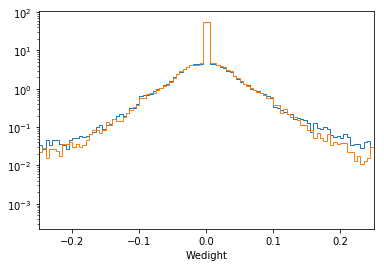

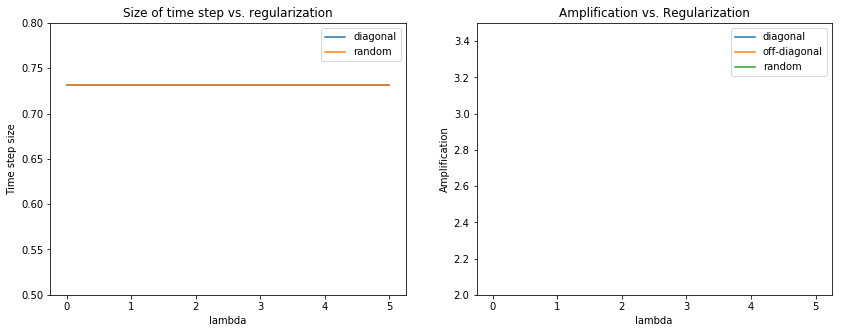

In [74]:
plt.hist(Phist_P[:,-1,-1,0],label='diagonal',normed=1, histtype='step',bins=np.arange(-0.5,0.5,0.005),log=True)
# plt.hist(Phist_C[:,-1,-1,0],label='off-diagonal',normed=1, histtype='step',bins=np.arange(-0.5,0.5,0.005),log=True)
plt.hist(Phist_R[:,-1,-1,0],label='random',normed=1, histtype='step',bins=np.arange(-0.5,0.5,0.005),log=True)
plt.xlim((-.25,.25))
plt.xlabel('Wedight')
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(lambdas,1/(1+np.exp(-np.mean(Phist_P[0,-1,:,:],axis=1).squeeze())),'-',label='diagonal')
# plt.plot(lambdas,1/(1+np.exp(-np.mean(Phist_C[0,-1,:,:],axis=1).squeeze())),'-',label='off-diagonal')
plt.plot(lambdas,1/(1+np.exp(-np.mean(Phist_R[0,-1,:,:],axis=1).squeeze())),'-',label='random')
plt.ylim((0.5,0.8))
plt.legend()
plt.title('Size of time step vs. regularization')
plt.ylabel('Time step size')
plt.xlabel('lambda')
plt.subplot(1,2,2)
plt.plot(lambdas,np.mean(Phist_P[1,-1,:,:],axis=1).squeeze(),'-',label='diagonal')
plt.plot(lambdas,np.mean(Phist_C[1,-1,:,:],axis=1).squeeze(),'-',label='off-diagonal')
plt.plot(lambdas,np.mean(Phist_R[1,-1,:,:],axis=1).squeeze(),'-',label='random')
plt.ylim((2,3.5))
plt.legend()
plt.title('Amplification vs. Regularization')
plt.ylabel('Amplification')
plt.xlabel('lambda')
plt.show()

In [ ]:
import pickle
pickle.dump([lambdas,N_EPHOCS,N_REPS,Phist_P,Phist_C,Phist_R,regval_P,regval_C,regval_R,test_acc_P, train_acc_P,test_acc_C, train_acc_C,test_acc_R, train_acc_R,test_loss_P, train_loss_P,test_loss_C, train_loss_C,test_loss_R, train_loss_R], open( "sess_params_0404.pkl", "wb" ) )

In [ ]:
# PCA on the weight space over time
from sklearn.decomposition import PCA
PCA()
# sklearn.decomposition.PCA()


In [172]:
# Test MLP on Anna Karenina
# Load Anna Karenina
from torch.utils.data import DataLoader # dataloader 
import sys
sys.path.insert(0,'../final_project/Data/')
from AnnaDataset import AnnaDataset, InvertAnna # import AK dataset

# params
BATCH_SIZE = 2048 # how many batches we are running
N_STEPS = 10 # How many characters are we inputting into the list at a time
N_HIDDEN_NEURONS = 512 # how many neurons per hidden layer
N_LAYERS = 2 # 2 hidden layers
N_EPOCHS = 11 # how many training epocs
learning_rates = np.asarray([1e-4,1e-6,1e-8]) # learning rates
N_REPS = 2 # len(learning_rates) # the number of learning repetitions

# load data
dataset = AnnaDataset(N_STEPS) # load the dataset
trainloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4) # create a DataLoader. We want a batch of BATCH_SIZE entries
testloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4) # create a DataLoader. We want a batch of BATCH_SIZE entries


N_INPUTS = len(dataset.categories) * N_STEPS # we want our MLP to have as many inputs as there are characters*letters in the text
print(N_INPUTS)
N_OUTPUTS = N_INPUTS # len(dataset.categories)  # we want to predict the next character in the text

# define the nnumber of parameters we need
def nparam_MLP(N_INPUTS,N_HIDDEN,N_OUTPUTS):
    input_to_hidden1 = (N_INPUTS+1)*N_HIDDEN #+1 for bias
    hidden1_to_hidden2 = (N_HIDDEN + 1)*N_HIDDEN
    hidden2_to_output = (N_OUTPUTS)*(N_HIDDEN+1)
    return(sum([input_to_hidden1,hidden1_to_hidden2,hidden2_to_output]))

N_PARAMS = nparam_MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS)
print(N_PARAMS)

770
1052418


In [166]:
x,y = next(iter(trainloader))
print(x.shape)#view(BATCH_SIZE,N_STEPS*N_CHAR).shape)

torch.Size([2048, 10, 77])


In [173]:
# regularizing digonal blocks of the partitioned RNN
train_loss_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
train_acc_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_loss_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_acc_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
Phist_P = np.zeros((N_PARAMS,N_EPHOCS,N_LAMBDA,N_REPS))

model_P = [None]*N_LAMBDA*N_REPS
regval_P = []
for r in tnrange(N_REPS):
    for k in tnrange(N_LAMBDA):
        reg_lambda = lambdas[k]
        # model_path = 'D:\chongguo\git\AM221pset\Project\Final Project\History\Lamb\model_P_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10))
        model_path = '/Users/vinayakvsv/am221/AM221pset/Project/vv_sandbox/mlp_experiments/model_P_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10))
        # model_P[k+r*N_LAMBDA] = PRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,1,device).to(device)
        model_P[k+r*N_LAMBDA] = MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS,device)
        l2_reg = torch.Tensor(1,device=device)
        optimizer = torch.optim.SGD(model_P[k+r*N_LAMBDA].parameters(), lr=1e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss() 
        # note that cross-entropy loss expects the indices of the class, not the one-hot. So, for A = [1,0,0,...] and B = [0,1,0,...], A is 0 and B is 1
        
        for epoch in range(N_EPHOCS):
            nps = 0
            running_train_loss=0
            running_train_acc=0
            model_P[k+r*N_LAMBDA].train()
            for p, param in enumerate(model_P[k+r*N_LAMBDA].parameters()):
                if param.requires_grad:
                    plist = torch.flatten(param.data)
                    for j in range(plist.size(0)):
                        while nps < Phist_P.shape[0]:
                            Phist_P[nps,epoch,k,r]=plist[j].item()
                            nps+=1

            for i, (x, y_tar) in enumerate(trainloader):
                l2_reg = 0
                x, y_tar = x.to(device), y_tar.to(device)
                optimizer.zero_grad()
                y_pred = model_P[k+r*N_LAMBDA](x.view(BATCH_SIZE,N_INPUTS))
                print(y_pred.view(BATCH_SIZE,N_OUTPUTS).shape)
                print(y_tar.shape)
                loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar) # what is the appropriate loss for AK? # look to HAMLET code...
                
                
                for p,param in enumerate(model_P[k+r*N_LAMBDA].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN_NEURONS and param.shape[1]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:gidx,:gidx].norm(p=1)
                            l2_reg = l2_reg + param[gidx:,gidx:].norm(p=1)
                        elif param.shape[1]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:,gidx:].norm(p=1)
                        elif param.shape[0]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:gidx,:].norm(p=1)
                regval_P.append(l2_reg.item())
                loss = loss + l2_reg*reg_lambda/BATCH_SIZE
                loss.backward()
                optimizer.step()
                running_train_loss+=loss.item()
                running_train_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar)
            
            running_test_acc=0
            running_test_loss=0
            model_P[k+r*N_LAMBDA].eval()
            for i,(x_test, y_test_tar) in enumerate(testloader):
                x_test, y_test_tar = x_test.to(device), y_test_tar.to(device)
                y_test_pred = model_P[k+r*N_LAMBDA](x_test.view(BATCH_SIZE,N_INPUTS))
                loss = criterion(y_test_pred.view(BATCH_SIZE,N_OUTPUTS),y_test_tar)
                running_test_loss+=loss.item()
                running_test_acc+=get_accuracy(y_test_pred.view(BATCH_SIZE,N_OUTPUTS), y_test_tar)
                
            train_loss_P[epoch,k,r] = running_train_loss/len(trainloader)
            train_acc_P[epoch,k,r] = running_train_acc/len(trainloader)
            test_loss_P[epoch,k,r] = running_test_loss/len(testloader)
            test_acc_P[epoch,k,r] = running_test_acc/len(testloader)
            
        # save the model and free the memory  
        torch.save(model_P[k+r*N_LAMBDA].state_dict(), model_path)
        model_P[k+r*N_LAMBDA] = [None]
        del(l2_reg,loss,optimizer,criterion,plist,param)

torch.Size([2048, 770])
torch.Size([2048, 10])


RuntimeError: multi-target not supported at /Users/soumith/mc3build/conda-bld/pytorch_1549593514549/work/aten/src/THNN/generic/ClassNLLCriterion.c:21